In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
import os


local_directory_path = r'/content/drive/MyDrive/Apple leaf dataset/data'

for dirname, _, filenames in os.walk(local_directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1032.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1026.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1033.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1016.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1027.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1025.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1024.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1038.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1003.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_101.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1010.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1036.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1008.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_0.jpg
/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1009.jpg

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(

    r'/content/drive/MyDrive/Apple leaf dataset/data',
    shuffle = True,
    image_size = (256,256),
    batch_size = 32,
)

Found 1730 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['healthy', 'rust', 'scab']

In [6]:
def get_dataset_partitions_tf(ds , train_split = 0.8 , val_split = 0.1 , test_split = 0.1 , shuffle = True , shuffle_size = 1000):

  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size , seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, RandomFlip, RandomRotation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

# ===================== 1. DEFINE INPUT & AUGMENTATION =====================

inputs = Input(shape=(256, 256, 3), name="input_image")

# Data Augmentation
x = RandomFlip("horizontal")(inputs)
x = RandomRotation(0.1)(x)

# ResNet50 specific preprocessing
#this will convert RGB to BGR and mean subtraction(ResNet needs)
x = Lambda(preprocess_input)(x)

# ===================== 2. LOAD RESNET50 BASE =====================

resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=x
)

# ===================== 3. FREEZING STRATEGY (Better approach) =====================


resnet_base.trainable = False

# Tumhara logic (Last 10 Unfreeze):
for layer in resnet_base.layers[-10:]:
    layer.trainable = True

# ===================== 4. GRAD-CAM & HEAD =====================

gradcam_layer_name = "conv5_block3_out"
gradcam_output = resnet_base.get_layer(gradcam_layer_name).output

x = GlobalAveragePooling2D(name="gap")(gradcam_output)
x = Dense(128, activation='relu', name="fc1")(x)
x = Dropout(0.5, name="dropout")(x)
outputs = Dense(3, activation='softmax', name="output")(x)

# ===================== 5. COMPILE =====================

model_resnet = Model(inputs=inputs, outputs=outputs, name="ResNet50_Cataract")

model_resnet.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ResNet50_Cataract"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 256, 256,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ random_rotation[… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ lambda[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 4,728,323 (18.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [10]:
# Train the model
history = model_resnet.fit(
    train_ds,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds,
    epochs = 20
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 568s 656ms/step - accuracy: 0.3561 - loss: 1.6829 - val_accuracy: 0.3938 - val_loss: 1.1463
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.4306 - loss: 1.2588 - val_accuracy: 0.6562 - val_loss: 0.8266
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.5110 - loss: 1.0040 - val_accuracy: 0.7312 - val_loss: 0.6631
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.6034 - loss: 0.8750 - val_accuracy: 0.7500 - val_loss: 0.5649
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.6934 - loss: 0.7288 - val_accuracy: 0.7625 - val_loss: 0.4990
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.7523 - loss: 0.6033 - val_accuracy: 0.8250 - val_loss: 0.4290
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.7821 - loss: 0.5382 - val_accuracy: 0.8313 - val_loss: 0.3883
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.8229 - loss: 0.4539 - val_accuracy: 

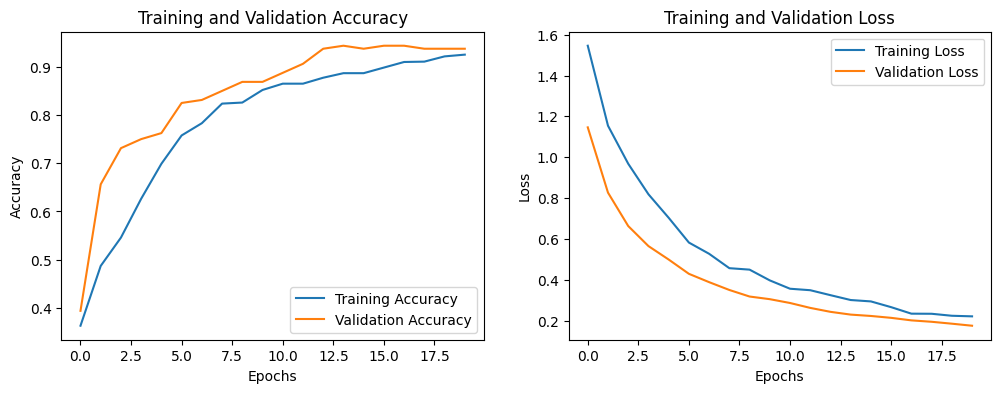

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 0.9649 - loss: 0.0743
Test Accuracy: 95.83%
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step

Classification Report:
              precision    recall  f1-score   support

     healthy       0.95      0.91      0.93        57
        rust       0.98      0.98      0.98        65
        scab       0.94      0.97      0.96        70

    accuracy                           0.96       192
   macro avg       0.96      0.96      0.96       192
weighted avg       0.96      0.96      0.96       192


Confusion Matrix:
[[52  1  4]
 [ 1 64  0]
 [ 2  0 68]]


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Evaluate the model
test_loss, test_accuracy = model_resnet.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')





y_true = []

for _, labels in test_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

# Agar labels one-hot encoded hain
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

# ===============================
# STEP 2: Model Predictions
# ===============================
y_pred = model_resnet.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# ===============================
# STEP 3: Classification Report
# ===============================
class_names = ['healthy', 'rust', 'scab']

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# ===============================
# STEP 4: Confusion Matrix
# ===============================
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

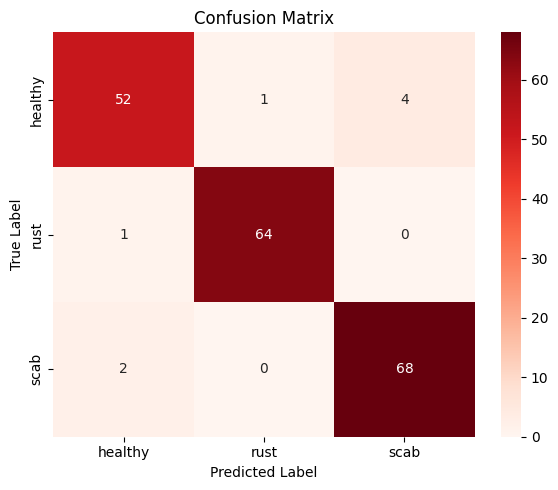

In [12]:
import seaborn as sns

# Plotting Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [13]:
import numpy as np

labels_set = set()

for _, labels in train_ds:
    labels_set.update(np.unique(labels.numpy()))

print("Label indices found:", labels_set)

Label indices found: {np.int32(0), np.int32(1), np.int32(2)}


Prediction: scab
Confidence: 0.7719


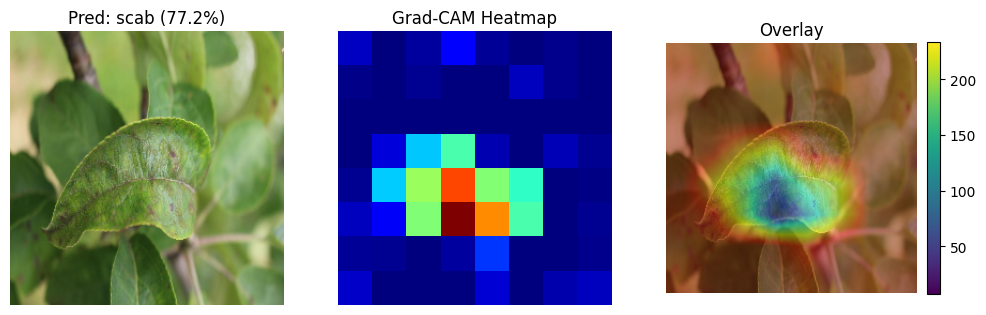

In [17]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# ===================== USER INPUT =====================
#img_path = "/content/drive/MyDrive/Apple leaf dataset/data/rust/Train_1019.jpg"
#img_path = "/content/drive/MyDrive/Apple leaf dataset/data/healthy/Train_1706.jpg"
img_path = "/content/drive/MyDrive/Apple leaf dataset/data/scab/Train_1038.jpg"
class_labels = ['healthy', 'rust', 'scab']
last_conv_layer_name = "conv5_block3_out"

# ===================== LOAD & PREPROCESS IMAGE =====================
target_size = (256, 256)
img = image.load_img(img_path, target_size=target_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# ===================== GRAD-CAM FUNCTION =====================
# ===================== CORRECTED GRAD-CAM FUNCTION =====================
def advanced_gradcam(model, img_array, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output,
        model.output]
    )


    input_data = {"input_image": img_array}

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_data)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_score = predictions[:, pred_index]

    grads = tape.gradient(class_score, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy(), predictions.numpy()

# ===================== RUN =====================

heatmap, preds = advanced_gradcam(
    model_resnet,
    img_array,
    last_conv_layer_name
)


pred_index = np.argmax(preds[0])
confidence = preds[0][pred_index]
predicted_label = class_labels[pred_index]

print(f"Prediction: {predicted_label}")
print(f"Confidence: {confidence:.4f}")



# ===================== VISUALIZATION =====================
img_original = cv2.imread(img_path)
img_original = cv2.resize(img_original, target_size)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

heatmap_resized = cv2.resize(heatmap, target_size)
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img_original, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_original)
plt.title(f"Pred: {predicted_label} ({confidence*100:.1f}%)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [18]:
## uncertanity

import numpy as np
import tensorflow as tf

# ===================== SETUP =====================

class_names = ['healthy', 'rust', 'scab']


input_data = {"input_image": img_array}

# ===================== UNCERTAINTY FUNCTION =====================
def predict_uncertainty(model, input_data, n_iter=50):

    print(f"Running {n_iter} simulations... (Please wait)")

    predictions = []
    for i in range(n_iter):

        preds = model(input_data, training=True)
        predictions.append(preds)

    predictions = np.array(predictions) # Shape: (50, 1, 3)

    # 1. Prediction (Mean): Average
    mean_probs = predictions.mean(axis=0)[0]
    pred_index = np.argmax(mean_probs)

    # 2. Uncertainty (Std Dev): How much Model confuse
    uncertainty_scores = predictions.std(axis=0)[0]

    return pred_index, mean_probs, uncertainty_scores

# ===================== RUN IT =====================
idx, mean_probs, uncertainties = predict_uncertainty(model_resnet, input_data, n_iter=50)

# Data extract
predicted_label = class_names[idx]
confidence = mean_probs[idx]
model_confusion = uncertainties[idx]

# ===================== REPORT PRINT KARO =====================
print("\n" + "="*40)
print(f"FINAL PREDICTION REPORT")
print("="*40)
print(f"Pred Class   : {predicted_label.upper()}")
print(f"Confidence   : {confidence * 100:.2f}%")
print(f"Uncertainty  : {model_confusion:.4f} (Lower is Better)")
print("-" * 40)

# Decision Logic
if model_confusion > 0.1:  # Threshold for High Confusion
    print("   STATUS: HIGH RISK")
    print("   Reason: The model gave different answers during testing.")
    print("   Action: Human Verification Required.")
elif confidence < 0.85:
    print("   STATUS: LOW CONFIDENCE")
    print("   Reason: Model is stable but not very sure (<85%).")
else:
    print("   STATUS: TRUSTWORTHY")
    print("   Reason: Model is confident and consistent.")
print("="*40)

Running 50 simulations... (Please wait)

FINAL PREDICTION REPORT
Pred Class   : SCAB
Confidence   : 66.54%
Uncertainty  : 0.1420 (Lower is Better)
----------------------------------------
   STATUS: HIGH RISK
   Reason: The model gave different answers during testing.
   Action: Human Verification Required.


In [19]:
## Ethics

import numpy as np

# ===================== SETUP =====================
class_names = ['healthy', 'rust', 'scab']

# ===================== ETHICAL FUNCTION =====================
def get_ethical_advice(model, img_array, safety_threshold=0.85):

    # 1. Dictionary Input
    input_data = {"input_image": img_array}

    # 2. Prediction
    preds = model.predict(input_data, verbose=0)

    pred_index = np.argmax(preds[0])
    label = class_names[pred_index]
    confidence = preds[0][pred_index]

    # ================= ETHICAL LOGIC START =================

    # Case A: Rust ya Scab
    if label != 'healthy':
        status = "ALERT: DISEASE DETECTED"
        advice = f"Action: Isolate this plant immediately. Treat for {label.upper()}."

    # Case B: Healthy , but confidence low (Risk)
    elif confidence < safety_threshold:
        status = "WARNING: LOW CONFIDENCE HEALTHY"
        advice = "Action: Model is not 100% sure. Please verify manually."

    # Case C: Healthy and confidence High (Safe)
    else:
        status = "STATUS: SAFE"
        advice = "Action: Plant looks healthy. No action needed."

    # ================= LOGIC END =================

    return status, advice, label, confidence

# ===================== RUN IT =====================

# Threshold 0.85 (85%) for safety
status, advice, final_label, conf = get_ethical_advice(model_resnet, img_array, safety_threshold=0.85)

print("\n" + "="*50)
print("ETHICAL AI CROP REPORT")
print("="*50)
print(f"AI Prediction  : {final_label.upper()}")
print(f"Confidence     : {conf*100:.2f}%")
print("-" * 50)
print(f"{status}")
print(f"{advice}")
print("="*50)


ETHICAL AI CROP REPORT
AI Prediction  : SCAB
Confidence     : 99.75%
--------------------------------------------------
ALERT: DISEASE DETECTED
Action: Isolate this plant immediately. Treat for SCAB.
